In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from data_reader import affretement, gen_dict_fourn, gen_camion_cap, gen_previsions_vente, gen_amortissement
from pfut import gen_usines_from_list, min_fourn_usine_i, min_fourn_usine_f, min_fourn_vente
from cout import cout_affretement,cout_amortissement

In [30]:
### Récupération des données des tableaux
dict_affretement = affretement()
dict_fourn = gen_dict_fourn(dict_affretement)
dict_camion = gen_camion_cap()
dict_previsions = gen_previsions_vente()
dict_amortissement = gen_amortissement()

In [31]:
### Set up d'une architecture
# Ordre des villes : 
#       ['Madrid','Marseille','Turin','Munich','Bruxelles']
table_usines_f = [
    [0,0,0,0,1],
    [0,0,0,1,0],
    [0,0,1,0,0],
    [0,1,0,0,0],
    [1,0,0,0,0],

    [0,0,0,1,1],
    [0,0,1,0,1],
    [0,1,0,0,1],
    [1,0,0,0,1],
    [0,0,1,1,0],
    [0,1,0,1,0],
    [1,0,0,1,0],
    [0,1,1,0,0],
    [1,0,1,0,0],
    [1,1,0,0,0],

    [0,0,1,1,1],
    [0,1,0,1,1],
    [1,0,0,1,1],
    [0,1,1,0,1],
    [1,0,1,0,1],
    [0,1,1,1,0],
    [1,0,1,1,0],
    [1,1,1,0,0],
    [1,1,0,0,1],
    [1,1,0,1,0],

    [0,1,1,1,1],
    [1,0,1,1,1],
    [1,1,0,1,1],
    [1,1,1,0,1],
    [1,1,1,1,0],

    [1,1,1,1,1]
]

In [32]:
def opti_archi(archi_f,archi_i) : ## Calcule la meilleure arborescence pour une architecture donnée
    ## Creation du dictionnaire des usines finales
    dict_usines_f = gen_usines_from_list(archi_f)
    ## Création du dictionnaire des usines intermédiaires
    dict_usines_i = gen_usines_from_list(archi_i)


    ##### Recherche des chemins les moins couteux

    ## Chemins optimaux pour les usines intermédiaires
    dict_usines_i_cost = min_fourn_usine_i(dict_usines_i, dict_fourn, dict_affretement, dict_camion)

    """# Affichage du dictionnaire de plus court chemin entre les usines intermédiaires et leurs fournisseurs
    print('Arborescence usine intermediaire :')
    for usine in dict_usines_i_cost.keys():
        dict_usine = dict_usines_i_cost[usine]
        print('\t', usine)
        for matiere in dict_usine.keys():
            print('\t\t', matiere, dict_usine[matiere])"""
        

    ## Chemins optimaux pour les usines finales
    dict_usines_f_cost = min_fourn_usine_f(dict_usines_f, dict_usines_i_cost, dict_fourn, dict_affretement, dict_camion)

    """# Affichage du dictionnaire de plus court chemin entre les usines finales et leurs fournisseurs
    print('\nArborescence usine finale :')
    for usine in dict_usines_f_cost.keys():
        dict_usine = dict_usines_f_cost[usine]
        print('\t',usine)
        for matiere in dict_usine.keys():
            print('\t\t', matiere, dict_usine[matiere])"""

            
    ## Chemins optimaux pour les points de ventes
    dict_vente_cost = min_fourn_vente(dict_usines_f_cost, dict_affretement, dict_camion, dict_previsions)

    """# Affichage du dictionnaire de plus court chemin entre les points de ventes et leurs fournisseurs
    print('\nArborescence point de vente :')
    for point_vente in dict_vente_cost.keys():
        dict_point_vente = dict_vente_cost[point_vente]
        print('\t',point_vente)
        for matiere in dict_point_vente.keys():
            print('\t\t', matiere, dict_point_vente[matiere])"""

    ##### Calcul du cout global 

    ## Calcul et affichage des couts
    cout_aff = cout_affretement(dict_vente_cost, dict_previsions)
    print('\t cout_aff = ',cout_aff)
    cout_amo = cout_amortissement(dict_usines_f, dict_usines_i, dict_amortissement)
    print('\t cout_amo = ',cout_amo)

    ##### Cascade pour répartir des volumes de demande dans les usines finales et intermédiaires
    for point_vente in dict_vente_cost.keys():
        dict_usines_f_cost[dict_vente_cost[point_vente]['Usine_f']]['Volume'] += dict_vente_cost[point_vente]['Volume']

    for usine_f in dict_usines_f_cost.keys():
        dict_usines_i_cost[dict_usines_f_cost[usine_f]['Usine_i'][0]]['Volume'] += dict_usines_f_cost[usine_f]['Volume']

    """##### Préparation a l'affichage du graph
    import networkx as nx
    import matplotlib.pyplot as plt
    dict_colors = {}
    color_index = 0
    G = nx.Graph()

    ## Creation noeud fournisseur
    for matiere in dict_fourn.keys():
        dict_colors['Fournisseur : '+matiere] = color_index
        color_index += 1
        for ville in dict_fourn[matiere]:
            if matiere=='Tube':
                subset = 9
            else:
                subset = 10
            volume = 0
            if matiere != 'Tube':
                for usine in dict_usines_i_cost.keys():
                    if dict_usines_i_cost[usine][matiere][0] == ville:
                        volume += dict_usines_i_cost[usine]['Volume']
            else:
                for usine in dict_usines_f_cost.keys():
                    if dict_usines_f_cost[usine][matiere][0] == ville:
                        volume += dict_usines_f_cost[usine]['Volume']
            G.add_node(matiere+ville, node_type='Fournisseur : '+matiere, place=ville, cout_unitaire = 0, subset=subset, volume=volume)"""


    """## Création noeud usine intermédiaire
    dict_colors['Usine intermédiaire'] = color_index
    color_index += 1
    for usine in dict_usines_i_cost.keys():
        G.add_node('Usine_i'+usine, node_type='Usine intermédiaire', place=usine, cout_unitaire = dict_usines_i_cost[usine]['totalCost'], subset=9, volume=dict_usines_i_cost[usine]['Volume'])
        i = 0
        for matiere in dict_usines_i_cost[usine].keys():
            if i<3:
                i+=1
                G.add_edge('Usine_i'+usine, matiere+dict_usines_i_cost[usine][matiere][0], volume=0)



    ## Création noeud usine finale
    dict_colors['Usine finale'] = color_index
    color_index += 1
    for usine in dict_usines_f_cost.keys():
        G.add_node('Usine_f'+usine, node_type='Usine finale', place=usine, cout_unitaire = dict_usines_f_cost[usine]['totalCost'], subset=8, volume=dict_usines_f_cost[usine]['Volume'])
        G.add_edge('Usine_f'+usine, 'Tube'+dict_usines_f_cost[usine]['Tube'][0], volume=0)
        G.add_edge('Usine_f'+usine, 'Usine_i'+dict_usines_f_cost[usine]['Usine_i'][0], volume=0)

    ## Création noeud point de vente
    dict_colors['Point de vente'] = color_index
    color_index += 1
    for site in dict_vente_cost.keys():
        G.add_node('Point de vente'+site, node_type='Point de vente', place=site, cout_unitaire = dict_vente_cost[site]['totalCost'], subset=7, volume=dict_vente_cost[site]['Volume'])
        G.add_edge('Point de vente'+site, 'Usine_f'+dict_vente_cost[site]['Usine_f'], volume=dict_vente_cost[site]['Volume'])

    
    ## Création de la liste des labels et répartition des couleurs
    labels = {n : G.nodes[n]['node_type']+'\n'+G.nodes[n]['place']+'\nVolume : '+str(G.nodes[n]['volume'])+f"\nCoût unitaire : {G.nodes[n]['cout_unitaire']:.2f}" for n in G.nodes}
    colors = [dict_colors[G.nodes[n]['node_type']] for n in G.nodes]
    sizes = []
    for n in list(G):
        sizes.append(G.nodes[n]['volume'])
"""

    """## Affichage
    pos = nx.multipartite_layout(G)
    nx.draw(G, with_labels=True, labels=labels, node_color = colors, pos=pos, node_size = sizes)
    plt.show()"""

    return (cout_aff,cout_amo)

In [33]:
df=[]
for archi in table_usines_f :
    couts = opti_archi(archi,archi)
    cout_aff, cout_amo = couts[0],couts[1]
    
    nb_usines_f = sum(archi)
    
    df.append([cout_aff,cout_amo,nb_usines_f]+archi)

df = pd.DataFrame(df,columns=["cout_aff","cout_amo",'nb_usines_f','Madrid','Marseille','Turin','Munich','Bruxelles'])

	 cout_aff =  67223.07447447447
	 cout_amo =  4395
	 cout_aff =  123888.09789789791
	 cout_amo =  4395
	 cout_aff =  119407.43243243244
	 cout_amo =  4395
	 cout_aff =  115474.63063063062
	 cout_amo =  4395
	 cout_aff =  159246.26066066066
	 cout_amo =  4395
	 cout_aff =  65839.3834565104
	 cout_amo =  4395
	 cout_aff =  63193.906066066076
	 cout_amo =  4395
	 cout_aff =  60996.24156156156
	 cout_amo =  4395
	 cout_aff =  61261.259579579586
	 cout_amo =  4395
	 cout_aff =  108457.53129129129
	 cout_amo =  4395
	 cout_aff =  103160.8111111111
	 cout_amo =  4395
	 cout_aff =  108389.04228228227
	 cout_amo =  4395
	 cout_aff =  111838.41729729729
	 cout_amo =  4395
	 cout_aff =  111946.89201201202
	 cout_amo =  4395
	 cout_aff =  110251.97057057057
	 cout_amo =  4395
	 cout_aff =  62426.07085648524
	 cout_amo =  4395
	 cout_aff =  60228.406351980724
	 cout_amo =  4395
	 cout_aff =  59877.56856161552
	 cout_amo =  4395
	 cout_aff =  59709.50732732733
	 cout_amo =  4395
	 cout_aff =  57496.

<AxesSubplot:>

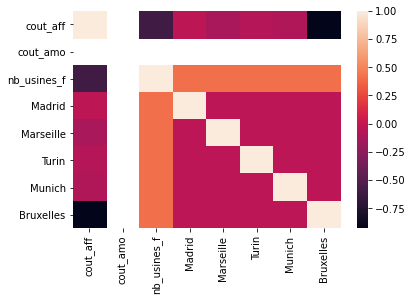

In [31]:
sns.heatmap(df.corr())

In [33]:
df[df['Bruxelles']==1]

,cout_aff,cout_amo,nb_usines_f,Madrid,Marseille,Turin,Munich,Bruxelles
0,67223.074474,4395,1,0,0,0,0,1
5,65839.383457,4395,2,0,0,0,1,1
6,63193.906066,4395,2,0,0,1,0,1
7,60996.241562,4395,2,0,1,0,0,1
8,61261.259580,4395,2,1,0,0,0,1
15,62426.070856,4395,3,0,0,1,1,1
16,60228.406352,4395,3,0,1,0,1,1
17,59877.568562,4395,3,1,0,0,1,1
18,59709.507327,4395,3,0,1,1,0,1
19,57496.411892,4395,3,1,0,1,0,1


In [34]:
df[df['Bruxelles']==0]

,cout_aff,cout_amo,nb_usines_f,Madrid,Marseille,Turin,Munich,Bruxelles
1,123888.097898,4395,1,0,0,0,1,0
2,119407.432432,4395,1,0,0,1,0,0
3,115474.630631,4395,1,0,1,0,0,0
4,159246.260661,4395,1,1,0,0,0,0
9,108457.531291,4395,2,0,0,1,1,0
10,103160.811111,4395,2,0,1,0,1,0
11,108389.042282,4395,2,1,0,0,1,0
12,111838.417297,4395,2,0,1,1,0,0
13,111946.892012,4395,2,1,0,1,0,0
14,110251.970571,4395,2,1,1,0,0,0


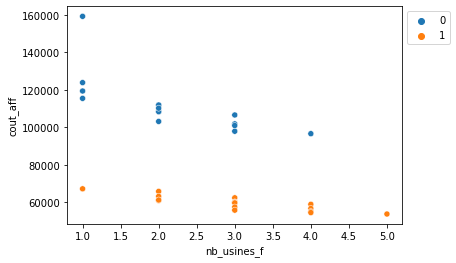

In [46]:
sns.scatterplot(x='nb_usines_f', y='cout_aff', hue='Bruxelles', data=df, )
plt.legend(bbox_to_anchor=(1, 1), loc=2) # Displays the legend outside the graph
plt.show()

In [15]:
nb_usines_f = 2


[[0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 1, 1],
 [0, 0, 1, 0, 1],
 [0, 1, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [0, 0, 1, 1, 0],
 [0, 1, 0, 1, 0],
 [1, 0, 0, 1, 0],
 [0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0],
 [1, 1, 0, 0, 0]]

In [36]:
bruss = [archi for archi in table_usines_f if archi[4]==1] ## tables des usines finales / Bruxelles est toujours présente

df2=[]
for archi_f in bruss :
    nb_usines_f = sum(archi_f)
    print(f"Finale : {archi_f}")

    table_usines_i = [archi for archi in table_usines_f if sum(archi)<=nb_usines_f] ## tables des usines intermédiaires, avec moins d’usines intermédiaires que d’usines finales

    for archi_i in table_usines_i :
        print(f"\t Inter : {archi_i}")
        couts = opti_archi(archi_f,archi_i)
        cout_aff, cout_amo = couts[0],couts[1]
        n_usines_i = sum(archi_i)
        

        df2.append([cout_aff,cout_amo,nb_usines_f,n_usines_i]+archi_f+archi_i)

df2 = pd.DataFrame(df2,columns=["cout_aff","cout_amo",'nb_usines_f','n_usines_i','Madrid_f','Marseille_f','Turin_f','Munich_f','Bruxelles_f','Madrid_i','Marseille_i','Turin_i','Munich_i','Bruxelles_i'])

Finale : [0, 0, 0, 0, 1]
	 Inter : [0, 0, 0, 0, 1]
	 cout_aff =  67223.07447447447
	 cout_amo =  4395
	 Inter : [0, 0, 0, 1, 0]
	 cout_aff =  131264.1937062811
	 cout_amo =  4395
	 Inter : [0, 0, 1, 0, 0]
	 cout_aff =  132938.79051626477
	 cout_amo =  4395
	 Inter : [0, 1, 0, 0, 0]
	 cout_aff =  130074.89530128932
	 cout_amo =  4395
	 Inter : [1, 0, 0, 0, 0]
	 cout_aff =  169671.27742712773
	 cout_amo =  4395
Finale : [0, 0, 0, 1, 1]
	 Inter : [0, 0, 0, 0, 1]
	 cout_aff =  65839.3834565104
	 cout_amo =  4395
	 Inter : [0, 0, 0, 1, 0]
	 cout_aff =  115484.40400568231
	 cout_amo =  4395
	 Inter : [0, 0, 1, 0, 0]
	 cout_aff =  123603.3387797378
	 cout_amo =  4395
	 Inter : [0, 1, 0, 0, 0]
	 cout_aff =  124566.10895398392
	 cout_amo =  4395
	 Inter : [1, 0, 0, 0, 0]
	 cout_aff =  166868.0805409002
	 cout_amo =  4395
	 Inter : [0, 0, 0, 1, 1]
	 cout_aff =  65839.3834565104
	 cout_amo =  4395
	 Inter : [0, 0, 1, 0, 1]
	 cout_aff =  65839.3834565104
	 cout_amo =  4395
	 Inter : [0, 1, 0, 0, 1

In [60]:
df2['cout_amo']=832*df2['n_usines_i']+47*df2['nb_usines_f']
df2['cout_tot']=df2.cout_aff+df2.cout_amo

In [66]:
df2[df2['cout_tot']<=59000].sort_values('cout_tot') #top des meilleures config --- À ne surtout pas manquer !!! La troisième va vous surprendre

,cout_aff,cout_amo,nb_usines_f,n_usines_i,Madrid_f,Marseille_f,Turin_f,Munich_f,Bruxelles_f,Madrid_i,Marseille_i,Turin_i,Munich_i,Bruxelles_i,cout_tot
363,53780.163890,3563,5,4,1,1,1,1,1,1,1,1,0,1,57343.163890
358,54717.123154,2731,5,3,1,1,1,1,1,1,1,0,0,1,57448.123154
298,55066.898124,2684,4,3,1,1,0,1,1,1,1,0,0,1,57750.898124
333,54547.999099,3516,4,4,1,1,1,0,1,1,1,1,0,1,58063.999099
328,55484.958363,2684,4,3,1,1,1,0,1,1,1,0,0,1,58168.958363
365,53780.163890,4395,5,5,1,1,1,1,1,1,1,1,1,1,58175.163890
362,54717.123154,3563,5,4,1,1,1,1,1,1,1,0,1,1,58280.123154
213,55834.733333,2637,3,3,1,1,0,0,1,1,1,0,0,1,58471.733333
302,55066.898124,3516,4,4,1,1,0,1,1,1,1,0,1,1,58582.898124
303,55066.898124,3516,4,4,1,1,0,1,1,1,1,1,0,1,58582.898124
